I usually try to keep dependencies to a minimum.  I'm able to do the analysis using NumPy, SciPy, pandas, scikit-learn, and pprint.

Start by importing the CSV files and and using methods that give a high-level overview of the data sets.

In [27]:
import numpy as np, pandas as pd
from pprint import pprint
path = 'C:/Users/Glenn Wright/Contacts/Documents/GitHub/homework/'
#path = 'C:/Users/M543015/Desktop/GitHub/homework/'
base = pd.read_csv(path+'meps_base_data.csv', sep=',')
meds = pd.read_csv(path+'meps_meds.csv', sep=',')

base.dtypes

Unnamed: 0                 int64
id                         int64
panel                      int64
pooledWeight             float64
age                        int64
sex                       object
race                      object
married                   object
highBPDiagnosed           object
diabetesDiagnosed         object
chdDiagnosed              object
miDiagnosed               object
anginaDiagnosed           object
strokeDiagnosed           object
emphysemaDiagnosed        object
asthmaDiagnosed           object
otherHDDiagnosed          object
heartFailureDiagnosed     object
dtype: object

In [3]:
base.head()

,Unnamed: 0,id,panel,pooledWeight,age,sex,race,married,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,miDiagnosed,anginaDiagnosed,strokeDiagnosed,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed
0,1,10007101,15,3603.881236,28,Male,White,MARRIED,Yes,No,No,No,No,No,No,No,No,No
1,2,10007102,15,2544.550424,25,Female,White,MARRIED,No,No,No,No,No,No,No,Yes,No,No
2,3,10007103,15,4050.397468,4,Male,White,UNDER 16 - INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No,Inapplicable,No
3,4,10007104,15,3064.059720,3,Female,White,UNDER 16 - INAPPLICABLE,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,Inapplicable,No,Inapplicable,No
4,5,10008101,15,3635.552466,51,Male,Multiple,MARRIED,No,No,No,No,No,No,No,No,No,No


In [5]:
meds.dtypes

Unnamed: 0        int64
id                int64
rxStartMonth      int64
rxStartYear       int64
rxName           object
rxNDC             int64
rxQuantity      float64
rxForm           object
dtype: object

In [7]:
meds.head()

,Unnamed: 0,id,rxStartMonth,rxStartYear,rxName,rxNDC,rxQuantity,rxForm
0,1,10007104,3,2011,AMOXICILLIN,143988775,75.0,SUSR
1,2,10007104,3,2011,OTIC EDGE SOLUTION,68032032814,14.0,SOL
2,3,10008102,3,2011,NASAL DECONGESTANT 0.05% SPRAY,63981056903,15.0,SPR
3,4,10008102,3,2011,NASAL DECONGESTANT 0.05% SPRAY,63981056903,15.0,SPR
4,5,10008102,9,2011,DIPHENHYDRAM,603333921,30.0,CAP


The two data sets have some time-related variables whose meaning isn't clear without some more context.  In this situation, I would ask detailed questions about the meanings of these variables.  Some of the starting months have negative values, which is interesting.

"Pooled weight" apparently weights the observations according to demographic values in the United States population.  I decided not to incorporate this data, both because of time constraints and because I didn't know the context for this data - for example, it wouldn't necessarily make sense to weight data according to United State demographics if I were building a model for patients in New Jersey.

The number of medicatios is very large, and it includes many duplicate names and NDC codes.  Without knowing more about the situation, I decided to use NDC codes as the unit of analysis.  I noticed that some of the NDC codes aren't "real" codes.  For example, "-9" seems to be a placeholder for a variety of medications.

In [18]:
mednames = meds[['rxNDC','rxName','id']]
mednames = mednames.drop_duplicates()
mednames = mednames.groupby(['rxNDC','rxName'], as_index=False).count()
mednames = mednames.sort_values(['rxName','id'], ascending=[True, False])
print mednames

             rxNDC                          rxName   id
35648  63653117105                     CLOPIDOGREL    1
35653  63653117106                     CLOPIDOGREL    1
12822    603385632      HYDROCHLOROTHIAZIDE (HCTZ)    1
7120     228282011             HYDROCHLOROTHIZAIDE    1
16481  13411011303                         LIPITOR    1
16222  12280013100          (ARMOUR) THYROID (1GR)    1
41608  86227090105                              -9    8
0               -9                              -9    5
16013  11673092740                              -9    4
1               -9               1 ANTI-INFECTIVES   54
15520   8881260148        1.5 INCH 27 GAUGE NEEDLE    1
15337   8290305620                    1/2ML TB SYR    2
38693  66993017520                              10    4
22216  50383023210                              10    2
34160  61314001910                              10    2
513        6351935                              10    1
516        6351936                              

Create some useful collections of medication and diseases metadata.

In [28]:
ndc = meds[['rxNDC','rxName','id']]
ndc = ndc.groupby(['rxNDC','rxName'], as_index=False).count()
ndc = ndc.sort_values(['rxNDC','id'], ascending=[True, False])
ndc = ndc.drop_duplicates()
ndc = dict(ndc[['rxNDC','rxName']].values.tolist())
pprint(ndc)

{-9L: '242 PSYCHOTHERAPEUTIC AGENTS',
 2080303L: 'DARVON',
 2197590L: 'AXIRON',
 2300475L: 'PROZAC WEEKL',
 2322730L: 'STRATTERA',
 2322830L: 'ATOMOXETINE HCL',
 2322930L: 'STRATTERA',
 2323030L: 'SYMBYAX',
 2323130L: 'SYMBYAX',
 2323230L: 'SYMBYAX',
 2323330L: 'SYMBYAX',
 2323430L: 'SYMBYAX',
 2323560L: 'CYMBALTA',
 2323704L: 'CYMBALTA',
 2323730L: 'CYMBALTA',
 2323733L: 'CYMBALTA',
 2323830L: 'STRATTERA',
 2323930L: 'STRATTERA',
 2324030L: 'CYMBALTA',
 2324033L: 'CYMBALTA',
 2324090L: 'CYMBALTA',
 2325030L: 'STRATTERA',
 2325130L: 'STRATTERA',
 2327001L: 'CYMBALTA',
 2327004L: 'CYMBALTA',
 2327030L: 'DULOXETINE HCL',
 2400630L: 'PROZAC',
 2411204L: 'ZYPREXA',
 2411230L: 'ZYPREXA',
 2411504L: 'ZYPREXA',
 2411530L: 'ZYPREXA',
 2411533L: 'ZYPREXA',
 2411630L: 'ZYPREXA',
 2411704L: 'ZYPREXA',
 2411730L: 'ZYPREXA 10MG',
 2411733L: 'ZYPREXA 10MG',
 2416502L: 'EVISTA (UNIT OF USE)',
 2416507L: 'EVISTA',
 2416530L: 'EVISTA',
 2416534L: 'RALOXIFENE HCL',
 2416579L: 'EVISTA',
 2441504L: 'ZYPRE

 29607212L: 'AUGMENTIN',
 29608012L: 'AUGMENTIN',
 29608522L: 'AUGMENTIN',
 29608539L: 'AUGMENTIN',
 29608612L: 'AMOXICILLIN/CLAVULANATE',
 29608621L: 'AUGMENTIN',
 29608739L: 'AUGMENTIN (ORANGE-RASPBERRY)',
 29608751L: 'AUGMENTIN (ORANGE-RASPBERRY)',
 29609022L: 'AUGMENTIN',
 29609023L: 'AUGMENTIN (ORANGE)',
 29609039L: 'AUGMENTIN',
 29609239L: 'AMOX TR-K CL',
 29609251L: 'AUGMENTIN (ORANGE-RASPBERRY)',
 29609425L: 'AUGMENTIN ES-600 (ORANGE-RASPBERRY)',
 29609440L: 'AUGMENTIN ES',
 29609446L: 'AUGMENTIN ES-600 (STRAWBERRY CREAM)',
 29609648L: 'AUGMENTIN XR',
 29609660L: 'AUGMENTIN XR SR',
 31223612L: 'PHENYLEPHRINE 2.5 %',
 31223812L: 'DIMETAPP',
 31225620L: 'DIMETAPP',
 31867012L: 'ROBITUSSIN MAXIMUM STRENGTH',
 31867810L: 'ROBITUSSIN-CF',
 31868512L: 'ROBITUSSIN DM (AF)',
 31868519L: 'ROBAFEN-DM',
 31868720L: 'ROBITUSSIN COUGH GELS LONG ACTING (NON-DROWSY,SOFT',
 31870618L: 'ROBITUSSIN D',
 32102301L: 'ESTRATEST H.S.',
 32102601L: 'ESTRATEST',
 32110201L: 'ACEON',
 32110301L: 'ACEON

 69265072L: 'PROCARDIA XL (FILM-COATED)',
 69266041L: 'PROCARDIA XL (FILM-COATED)',
 69266066L: 'PROCARDIA XL',
 69267066L: 'PROCARDIA XL (FILM-COATED)',
 69296030L: 'CADUET',
 69305107L: 'ZITHROMAX',
 69305175L: 'ZITHROMAX (SINGLE DOSE PACKETS)',
 69306030L: 'ZITHROMAX (FILM-COATED)',
 69306075L: 'AZITHROMYCIN (ZITHROMAX)',
 69306086L: 'ZITHROMAX',
 69307030L: 'ZITHROMAX',
 69307075L: 'AZITHROMYCIN',
 69311019L: 'ZITHROMAX',
 69312019L: 'ZITHROMAX',
 69313019L: 'ZITHROMAX',
 69314019L: 'ZITHROMAX',
 69315083L: 'ZITHROMAX IV',
 69323066L: 'FELDENE',
 69324122L: 'CIPROFLOXACN',
 69417021L: 'ZMAX (CHERRY-BANANA)',
 69419068L: 'REVATIO/STERIL/ORA-SWEET',
 69420030L: 'VIAGRA',
 69421030L: 'VIAGRA',
 69422030L: 'VIAGRA',
 69422066L: 'VIAGRA',
 69431071L: 'MINIPRESS',
 69541066L: 'VISTARIL',
 69542066L: 'VISTARIL',
 69544093L: 'VISTARIL',
 69550066L: 'ZYRTEC (FILM-COATED)',
 69551066L: 'ZYRTEC (FILM-COATED)',
 69553047L: 'CETIRIZINE HCL',
 69553093L: 'ZYRTEC',
 71000724L: 'DILANTIN',
 710007

 93078205L: 'TAMOXIFEN',
 93078210L: 'TAMOXIFEN',
 93078256L: 'TAMOXIFEN CITRATE',
 93078405L: 'TAMOXIFEN CITRATE',
 93078406L: 'TAMOXIFEN CITRATE',
 93078486L: 'TAMOXIFEN CITRATE',
 93078701L: 'ATENOLOL',
 93078710L: 'ATENOLOL',
 93079401L: 'NICARDIPINE HCL',
 93081001L: 'NORTRIPTYLINE HCL',
 93081005L: 'NORTRIPTYLINE HYDROCHLORIDE',
 93081101L: 'NORTRIPTYLINE HCL',
 93081105L: 'NORTRIPTYLINE HYDROCHLORIDE',
 93081201L: 'NORTRIPTYLIN',
 93081205L: 'NORTRIPTYLINE HYDROCHLORIDE',
 93081301L: 'NORTRIPTYLINE HCL',
 93081901L: 'NIFEDICAL XL',
 93081955L: 'NIFEDICAL XL',
 93083201L: 'CLONAZEPAM',
 93083205L: 'CLONAZEPAM',
 93083210L: 'CLONAZEPAM',
 93083293L: 'CLONAZEPAM',
 93083301L: 'CLONAZEPAM',
 93083305L: 'CLONAZEPAM',
 93083310L: 'CLONAZEPAM',
 93083401L: 'CLONAZEPAM',
 93083405L: 'CLONAZEPAM',
 93084015L: 'KETOCONAZOLE TOPICAL',
 93084030L: 'KETOCONAZOLE TOPICAL',
 93084092L: 'NYSTATI/HYDROC/TETRAC/DIPHEN',
 93085101L: 'METRONIDAZOLE (USP)',
 93085105L: 'METRONIDAZOLE',
 93085205L: '

 93894701L: 'ACYCLOVIR (COMPRESSED)',
 93894705L: 'ACYCLOVIR',
 93910729L: 'MEBENDAZOLE',
 93911101L: 'PRENATAL PLUS',
 93912830L: 'CLOBETASOL',
 93912895L: 'CLOBETASOL PROPIONATE',
 93913306L: 'AMIODARONE HYDROCHLORIDE',
 93913352L: 'AMIODARONE HYDROCHLORIDE',
 93915810L: 'MULTIVIT/FL',
 93920031L: 'LIDOCAINE HCL',
 93922501L: 'POTASSIUM CHLORIDE SA',
 93936401L: 'GLYBURIDE TAB 5MG,CAJ',
 93936405L: 'GLYBURIDE',
 93936410L: 'GLYBURIDE',
 93938001L: 'URSODIOL',
 93943301L: 'GLYBURIDE',
 93943305L: 'GLYBURIDE',
 93947753L: 'GLYBURIDE',
 93960412L: 'HALOPERIDOL LACTATE',
 93963316L: 'VALPROIC ACID (CHERRY-MINT)',
 93963487L: 'MEGESTROL ACETATE (APRICOT)',
 93964301L: 'PROCHLORPERAZINE MALEATE',
 93965015L: 'CLOBETASOL PROPIONATE',
 93965030L: 'CLOBETASOL PROPIONATE',
 93965201L: 'PROCHLORPER',
 93966016L: 'ETHOSUXIMIDE',
 93977401L: 'HYDROXYCHLOROQUINE SULFATE',
 93977405L: 'HYDROXYCHLOROQUINE SULFATE',
 95000601L: 'LODRANE 12 HOUR (DYE-FREE)',
 95006716L: 'PNEUMOTUSSIN 2.5 (AF,SF,DYE-FR

 168025846L: 'CLOTRIM/BETA',
 168026315L: 'ALCLOMETASONE DIPROPIONATE',
 168026360L: 'ALCLOMETASONE DIPROPIONATE',
 168026415L: 'ALCLOMETASON',
 168026460L: 'ALCLOMETASONE DIPROPIONATE',
 168026515L: 'BETAMETHASONE DIPROPIONATE AUGMENTE',
 168026550L: 'BETAMETHASONE DIPROPIONATE, AUGMENTED',
 168026615L: 'BETAMETHASONE DIPROPIONATE AUGMENTE (AUGMENTED)',
 168026730L: 'AUG BETAMET',
 168026760L: 'BETAMETHASONE DIPROPIONATE (USP)',
 168026815L: 'BETAMETHASONE DIPROPIONATE, AUGMENTED',
 168026850L: 'BETAMETHASONE DIPROPIONATE, AUGMENTED',
 168026950L: 'CLOBETASOL PROPIONATE',
 168027015L: 'MOMETASONE',
 168027046L: 'MOMETASONE',
 168027146L: 'MOMETASONE FUROATE',
 168027260L: 'MOMETASONE FUROATE',
 168027545L: 'METRONIDAZOLE TOPICAL',
 168027740L: 'CLINDAMYCIN',
 168027830L: 'AMCINONIDE',
 168028704L: 'HYDROCORTISONE',
 168028802L: 'HYDROCORTISONE',
 168029330L: 'CLOBETASOL PROPIONATE',
 168029360L: 'CLOBETASOL PROPIONATE',
 168030160L: 'CLOBETASOL PROPIONATE EMOLLIENT',
 168030915L: 'DES

 182503160L: 'CLOTRIMAZOLE',
 182507460L: 'MICONAZOLE NITRATE',
 182507945L: 'EUCERIN',
 182509534L: 'CLOTRIMAZOLE',
 182512852L: 'CAPSAICIN',
 182600964L: 'ACETAMINOPHEN',
 182602240L: 'BROMATANE DX',
 182602464L: 'EAR DROPS',
 182606437L: 'GUIATUSS DM',
 182606440L: 'GUIATUSS DM',
 182607240L: 'LACTULOSE',
 182608440L: 'MILK OF MAGNESIA',
 182608837L: 'SELENIUM SULFIDE',
 182609667L: 'POLYVITAMIN WITH FLUORIDE (DROPS)',
 182613577L: 'NASAL',
 182615140L: 'VITAMIN LIQUID',
 182615537L: 'COUGH/COLD FORMULA PEDIATRIC',
 182616039L: 'ANTACID',
 182616837L: 'HYDRAMINE (AF)',
 182616840L: 'HYDRAMINE (AF)',
 182708264L: 'HYPROMELLOSE',
 182709911L: 'PROMETHAZINE',
 182820300L: 'LABETALOL',
 182820389L: 'LABETALOL',
 182821589L: 'SENNOSIDES',
 182821789L: 'ASPIRIN',
 182822200L: 'PHENERGAN',
 182822689L: 'DILTIAZEM',
 182822789L: 'DILTIAZEM ER',
 182823300L: 'NIFEDIPINE ER',
 182823389L: 'NIFEDIPINE ER',
 182823489L: 'NIFEDIAC CC',
 182823500L: 'ATENOLOL',
 182823589L: 'ATENOLOL',
 182823689

 247006298L: 'IBUPROFEN',
 247006407L: 'DURICEF',
 247006940L: 'PENICILLIN VK',
 247007135L: 'PREDNISONE',
 247007210L: 'PREDNISONE',
 247007222L: 'PREDNISONE',
 247007227L: 'PREDNISONE',
 247007230L: 'PREDNISONE',
 247007242L: 'PREDNISONE',
 247007245L: 'PREDNISONE',
 247007280L: 'PREDNISONE',
 247007403L: 'NAPROXEN SODIUM',
 247007808L: 'ACETAMINOPHEN W/CODEINE #3',
 247007810L: 'ACETAMINOPHEN-CODEINE',
 247007820L: 'ACETAMINOPHEN W/ CODEINE',
 247007824L: 'ACETAMINOPHEN/CODEINE',
 247007900L: 'HYDROCODONE/APAP',
 247007902L: 'HYDROCODONE/ACETAMINOPH',
 247007906L: 'HYDROCODONE/APAP',
 247007907L: 'HYDROCODONE/ACETAMINOPHEN',
 247007920L: 'HYDROCODONE/APAP',
 247007924L: 'HYDROCODONE/APAP',
 247007930L: 'HYDROCODONE/APAP',
 247007998L: 'HYDROCODONE/APAP',
 247008003L: 'IBUPROFEN',
 247008060L: 'IBUPROFEN',
 247008524L: 'APAP/CODEINE',
 247008616L: 'PROPOX-N/APAP',
 247008698L: 'PROPOXY-N/APAP',
 247008820L: 'CARISOPRODOL',
 247009214L: 'PIROXICAM',
 247009315L: 'MECLIZINE',
 24700932

 378071501L: 'TIMOLOL MAL',
 378072219L: 'TIZANIDINE',
 378072301L: 'ENALAPRIL/HCTZ',
 378072419L: 'TIZANIDINE HYDROCHLORIDE',
 378073101L: 'PROPRAN/HCTZ',
 378075101L: 'CYCLOBENZAPRINE',
 378075105L: 'CYCLOBENZAPR',
 378075110L: 'CYCLOBENZAPRINE HCL',
 378075193L: 'FLEXERIL',
 378075201L: 'FEXOFENADINE',
 378075301L: 'FEXOFENADINE',
 378075305L: 'FEXOFENADINE HCL',
 378075501L: 'FEXOFENADINE HCL',
 378075505L: 'FEXOFENADINE HCL',
 378075701L: 'ATENOLOL',
 378075710L: 'ATENOLOL',
 378075793L: 'ATENOLOL',
 378077101L: 'CYCLOBENZAPRINE HYDROCHLORIDE',
 378077193L: 'CYCLOBENZAPR',
 378077201L: 'VERAPAMIL HYDROCHLORIDE',
 378077205L: 'VERAPAMIL',
 378077701L: 'LORAZEPAM',
 378078105L: 'FEXOFENADINE HCL',
 378078205L: 'FEXOFENADINE-PO 180MG TAB',
 378081001L: 'HYDROCHLOROT',
 378081005L: 'HYDROCHLOROTHIAZIDE',
 378081093L: 'HYDROCHLOROT',
 378086005L: 'CLOZAPINE (MYLAN)',
 378087399L: 'CLONIDINE',
 378100501L: 'AZATHIOPRINE',
 378101001L: 'PIROXICAM',
 378101201L: 'HYDROCHLOROTHIAZIDE-LISIN

 406036301L: 'ACETAMINOPHEN-HYDROCODONE BITARTRATE',
 406036305L: 'HYDROCO/APAP',
 406036501L: 'APAP/HYDROCODONE BITARTRATE',
 406036505L: 'HYDROCO/APAP',
 406036562L: 'APAP/HYDROCODONE BITARTRATE (10X10)',
 406036601L: 'ACETAMINOPHEN-HYDROCODONE BITARTRATE',
 406036662L: 'HYDROCO/APAP',
 406036701L: 'HYDROCODONE/APAP',
 406036705L: 'HYDROCODONE/ APAP',
 406037516L: 'ACETAMINOPHEN-HYDROCODONE BITARTRATE',
 406048401L: 'CODEINE',
 406048403L: 'TYLENOL W/ CODEINE',
 406048410L: 'TYLENOL/COD',
 406048420L: 'TYLENOL W/CODEINE #3',
 406048450L: 'TYLENOL #3',
 406048501L: 'ACETAMINOPHEN-CODEINE PHOSPHATE',
 406048505L: 'APAP/CODEINE',
 406051201L: 'PERCOSET',
 406051205L: 'OXYCODONE/APAP',
 406051262L: 'OXYCODONE/ACETAMINOPHEN',
 406052201L: 'OXYCOD-APAP',
 406052301L: 'APAP/OXYCODONE',
 406053201L: 'APAP/OXYCODONE',
 406055201L: 'ROXICODONE',
 406055262L: 'OXYCODONE',
 406055401L: 'OXYCODONE HCL',
 406058201L: 'OXYCOD/APAP',
 406058262L: 'OXYCOD/APAP',
 406059301L: 'OXYCODONE HYDROCHLORIDE'

 472162828L: 'PROMETHAZINE VC PLAIN',
 472162916L: 'PROMETH VC /CODEINE',
 472163004L: 'PROMETHAZINE',
 472163016L: 'PROMETHAZINE DM SYRUP',
 472173803L: 'MICONAZOLE NITRATE',
 472180016L: 'ZINC OXIDE',
 472500060L: 'LACTULOSE',
 472500208L: 'PHENYTOIN',
 472524267L: 'PERMETHRIN',
 472524269L: 'PERMETHRIN LOTION',
 482006206L: 'PAMINE FORTE',
 482015706L: 'GLUTOFAC-MX (6X10,BLISTER PK,CAPLET)',
 482018110L: 'DECONAMINE SR',
 482311010L: 'ENTSOL (HYPERTONIC,PF)',
 482400030L: 'FLORAGEN',
 482476015L: 'TYZINE',
 482477015L: 'TYZINE NASAL',
 482480124L: 'PERANEX HC',
 485004150L: 'DOXYCYCLIN',
 485005101L: 'UROGESIC-BLUE',
 485005216L: 'ED-TLC',
 485005401L: 'ED A-HIST (CAPLET)',
 485005516L: 'ED A-HIST (GRAPE)',
 485005708L: 'ED APAP',
 485006501L: 'ED CYTE F',
 485007116L: 'ED-A-HIST DM (AF,SF,BANANA)',
 485007201L: 'ED-CHLOR-TAN',
 485007402L: 'ED CHLORPED',
 485015516L: 'ED A-HIST',
 486111101L: 'K-PHOS',
 486111401L: 'UROQID-ACID NO. 2 (CAPLET)',
 487020101L: 'ALBUTEROL/IPRATROP',
 4

 574205912L: 'CICLOPIROX',
 574206045L: 'CICLOPIROX OLAMINE',
 574212128L: 'AMMONIUM LACTATE',
 574212138L: 'AMMONIUM LAC',
 574400910L: 'NEOMYCIN AND POLYMYXIN B SULFATES A (1X10ML,USP)',
 574709012L: 'HYDROCORTISONE ACETATE',
 574722010L: 'TRIMETHOBENZAMIDE HCL PEDIATRIC',
 574722612L: 'COMPAZINE',
 574723412L: 'PROMETHAZINE',
 574723612L: 'PROMETHAZINE',
 591001310L: 'PRAVASTATIN',
 591001319L: 'PRAVASTATIN',
 591001419L: 'PRAVASTATIN NA',
 591001619L: 'PREVASTATIN NA',
 591001919L: 'PRAVASTATIN SODIUM',
 591003104L: 'ALENDRONATE SODIUM',
 591007704L: 'ALENDRONATE',
 591024001L: 'ATIVAN',
 591024005L: 'ATIVAN',
 591024010L: 'LORAZEPAM',
 591024101L: 'LORAZEPAM',
 591024105L: 'LORAZEPAM',
 591024110L: 'LORAZEPAM',
 591024201L: 'LORAZEPAM',
 591024205L: 'LORAZEPAM',
 591024210L: 'LORAZEPAM',
 591030001L: 'FUROSEMIDE',
 591030010L: 'FUROSEMIDE',
 591030101L: 'FUROSEMIDE',
 591030110L: 'FUROSEMIDE (USP)',
 591030201L: 'FUROSEMIDE',
 591030205L: 'FUROSEMIDE (USP)',
 591033501L: 'ACYCLOVI

 603033121L: 'VITAMIN E',
 603038046L: 'SODIUM CHLORIDE',
 603041054L: 'VITAMIN A & D OINTMENT',
 603044150L: 'BACITRACIN',
 603051235L: 'GLYCERIN',
 603053450L: 'HYDROCORTISONE (6 PANEL BOX)',
 603053550L: 'HYDROCORTISONE (4 PANEL BOX)',
 603064888L: 'CAPSAICIN',
 603064988L: 'CAPSAICIN',
 603069457L: 'ANTACID (MINT CREME,MINT)',
 603071257L: 'ANTACID M PLUS',
 603074758L: 'DOC-Q-LACE',
 603076247L: 'FERROUS SULFATE (DROPS)',
 603076358L: 'FERROUS SULFATE',
 603078757L: 'MILK OF MAGNESIA',
 603082354L: 'Q-DRYL (AF,CHERRY)',
 603082358L: 'DIPHENHYDRAMINE',
 603082381L: 'Q-DRYL',
 603082394L: 'Q-DRYL 12.5MG/5ML ELIXIR',
 603083873L: 'Q-PAP INFANT',
 603083954L: 'NORTEMP',
 603083958L: "CHILDREN'S Q-PAP (W/ MEASURING CUP,AF)",
 603083994L: 'TYLENOL',
 603084054L: 'Q-PAP',
 603084094L: "CHILDREN'S Q-PAP (UNBOXED,W/MEASURING CUP)",
 603084154L: 'Q-PAP',
 603084254L: 'Q-PAP',
 603084354L: 'Q-PAP',
 603085156L: 'Q-TAPP (AF,GRAPE)',
 603085194L: 'Q-TAPP (UNBOXED,AF,GRAPE)',
 603085294L: 'Q-TA

 642020010L: 'STROVITE',
 642020110L: 'STROVITE PLU',
 642020790L: 'STROVITE ONE',
 642020810L: 'STROVITE',
 642020930L: 'STROVITE ADVANCE+D',
 642045516L: 'TUSSAFED-HCG',
 642046116L: 'TUSSO-C (AF,SF,DYE-FREE)',
 642061616L: 'TUSSO-XR (AF,SF,GLUTEN-FREE)',
 642064510L: 'TUSSO-DMR',
 642274690L: 'RENAX',
 642275590L: 'RENAX',
 677006901L: 'FERROUS GLUCONATE',
 677007001L: 'FERROUS SULFATE',
 677007010L: 'FERROUS SULFATE (GREEN,FILM-COATED)',
 677007101L: 'FERROUS SULFATE (RED,FILM-COATED)',
 677007110L: 'FERROUS SULFATE',
 677011701L: 'PREDNISONE',
 677011710L: 'PREDNISONE',
 677013110L: 'SODIUM BICARBONATE',
 677016301L: 'UNI DAILY',
 677019101L: 'DOCUSATE SOD',
 677019110L: 'DOCUSATE SOD',
 677019201L: 'DOCUSATE SODIUM (SOFTGEL)',
 677042505L: 'NIACIN SR (NIASPAN)',
 677042701L: 'PREDNISONE',
 677042705L: 'PREDNISONE',
 677042710L: 'PREDNISONE',
 677043001L: 'METHOCARBAMOL',
 677047601L: 'AMITRIPTYLINE',
 677047701L: 'AMITRIPTYLIN',
 677056801L: 'ELAVIL',
 677058910L: 'CARISOPRODOL',

 781706761L: 'MOMETASONE',
 781706827L: 'MOMETASONE FUROATE',
 781707427L: 'AUG BETAMET',
 781707450L: 'AUG BETAMET',
 781707787L: 'METRONIDAZOLE (W/ 5 VAG APPLICATORS)',
 781707819L: 'METRONIDAZOLE TOPICAL',
 781709004L: 'KETOCONAZOLE',
 781710660L: 'CICLOPIROX',
 781710955L: 'FENTANYL',
 781711155L: 'FENTANYL',
 781711255L: 'FENTANYL',
 781711355L: 'FENTANYL',
 781711455L: 'FENTANYL',
 781715564L: 'ALBUTEROL',
 781724155L: 'FENTANYL',
 781724255L: 'FENTANYL',
 781724355L: 'FENTANYL',
 781724455L: 'FENTANYL',
 781884001L: 'METHYLPHENIDATE HCL',
 781884201L: 'METHYLPHENIDATE',
 785112201L: 'LORCET PLUS',
 785112250L: 'LORCET PLUS',
 785635001L: 'LORCET 10/650',
 785635050L: 'LORCET',
 785635063L: 'LORCET',
 799000104L: 'CALMOSEPTINE',
 802392392L: 'SF',
 802395319L: 'HYDROCORT',
 813001206L: 'FERRETTS',
 813020201L: 'O-CAL PRENATAL',
 813079955L: 'FEM PH',
 813931601L: 'O-CAL F.A.',
 832003800L: 'OXYBUTYNIN',
 832003850L: 'OXYBUTYNIN',
 832004209L: 'AMLODIPINE BESYLATE',
 832004309L: '

 8290001118L: 'NEEDLES',
 8290001172L: 'NEEDLE',
 8290006893L: 'BD SINGLE USE SWAB',
 8290020003L: 'SYRINGE/NEEDLE (22G DRAW - 25H 1.5 " INJECT)',
 8290032005L: 'BD NORMAL SALINE FLUSH',
 8290207227L: 'ELBOW BRACE',
 8290207231L: 'ANKLE BRACE',
 8290236712L: 'BD LACTINEX (1GMX12)',
 8290305122L: 'B-D NEEDLES REGULAR BEVEL (25GX5/8)',
 8290305127L: 'B-D NEEDLES REGULAR BEVEL (25GX1-1/2)',
 8290305156L: 'B-D NEEDLES REGULAR BEVEL (22GX1-1/2)',
 8290305462L: 'B-D LAB SYRINGE ECCENTRIC TIP (10CC, NON-STERILE)',
 8290305543L: 'SHARPS',
 8290305620L: '1/2ML TB SYR',
 8290306546L: 'NORMAL SALIN',
 8290309570L: '3ML LL SYRNG',
 8290309574L: 'B-D SYRINGE/NEEDLE COMBO LUER-LOK (22GX1-1/2, 3CC)',
 8290309581L: 'B-D SYRINGE/NEEDLE COMBO LUER-LOK (25GX1, 3CC)',
 8290309582L: '3ML LL SYRNG',
 8290309585L: 'BD 3ML LUER-LOK SYRINGE',
 8290309589L: 'B-D SYRINGE/NEEDLE COMBO LUER-LOK (23G, IM, 1-1/2,',
 8290309623L: '1ML TB SYRNG',
 8290309628L: 'ULTRA COMFORT SYRINGE',
 8290309629L: 'INSULIN',
 8290320

 11917005025L: 'CALCIUM/VITAMIN D',
 11917005507L: 'ELECTROLYTE PEDIATRIC (UNFLAVORED)',
 11917005585L: 'PEDIATRIC ELECTROLYTE FRUIT',
 11917005831L: 'VITAMIN D OTC',
 11917006275L: 'ETHY ALCOHOL',
 11917006307L: 'IBUPROFEN',
 11917006380L: 'PILL CUTTER PLAIN',
 11917006505L: 'NUCUS REFLIEF',
 11917006545L: 'CYANOCOBALAMIN',
 11917006914L: 'HYDROCORT',
 11917007452L: 'MULTIPLE VIT',
 11917007543L: 'CALCIUM 500 + D',
 11917007548L: 'CALCIUM 600',
 11917007569L: 'FERROUS SULFATE',
 11917007630L: 'VITAMIN D',
 11917009061L: 'EYE ITCH REL',
 11917009215L: 'FERROUS SULF',
 11917009216L: 'FERROUS SULFATE',
 11917009246L: 'OMEGA-3',
 11917009248L: 'VITAMIN D',
 11917009900L: 'BIOTIN',
 11917010158L: 'WAL-TUSSIN',
 11917010170L: 'CYANOCOBALAMIN',
 11917010220L: 'ARTIFICIAL TEARS',
 11917010655L: 'MAG CITRATE',
 11917010788L: 'EAR WAX KIT',
 11917011271L: 'PAIN AND FEVER',
 11917011335L: 'CA CITRATE',
 11980001105L: 'BLEPH',
 11980002205L: 'BLEPHAMIDE',
 11980002210L: 'BLEPHAMIDE',
 11980017405

 16590001028L: 'AMBIEN',
 16590001056L: 'AMBIEN',
 16590001060L: 'AMBIEN',
 16590001160L: 'AMITRIPTYLINE HCL',
 16590001260L: 'ELAVIL',
 16590001272L: 'AMITRIPTYLINE',
 16590001282L: 'AMITRIPTYLINE 25MG',
 16590001360L: 'AMITRIPTYLINE',
 16590001532L: 'AMOXICILLIN',
 16590001533L: 'AMOXICILLIN',
 16590001604L: 'AMOXICILLIN',
 16590001615L: 'AMOXICILLIN',
 16590001630L: 'AMOXICILLIN',
 16590001833L: 'AMOXICILLIN 125MG/5ML SUSP 150ML',
 16590002014L: 'AMOX-CLAV',
 16590002020L: 'AMOX-CLAV 875MG',
 16590002028L: 'AMOX TR-K CLV',
 16590002140L: 'APAP W/HYDROCODONE',
 16590002372L: 'ACETAMINOPHEN/CODEINE',
 16590002815L: 'BACTROBAN',
 16590003120L: 'BENZONATATE',
 16590003315L: 'CLOTRIM/BETAMETH',
 16590003962L: 'CARISPRODOL',
 16590004033L: 'CEFACLOR',
 16590004121L: 'CECLOR PULVULES',
 16590004775L: 'PROMETHAZINE',
 16590005140L: 'CEPHALEXIN',
 16590005414L: 'CIPROFLOXACIN',
 16590005420L: 'CIPROFLOXACIN HCL',
 16590005430L: 'CIPROFLOXACIN HCL',
 16590005962L: 'CLONAZEPAM 1MG TABLETS',
 1

 21695029400L: 'AMOXICILLIN',
 21695029615L: 'EFFEXOR XR',
 21695029730L: 'FAMOTIDINE',
 21695029830L: 'METOPROLOL TARTRATE (CAPLET)',
 21695029860L: 'METOPROLOL',
 21695029890L: 'METOPROLOL',
 21695029900L: 'METOPROLOL TARTRATE',
 21695030115L: 'PHENAZOPYRID',
 21695030642L: 'PREDNISONE',
 21695030721L: 'PREDNISONE',
 21695030730L: 'PREDNISONE',
 21695030821L: 'METRONIDAZOLE',
 21695031430L: 'AMOXICILLIN',
 21695031530L: 'AMOXICILLIN',
 21695031542L: 'AMOXICILLIN',
 21695031714L: 'CEPHALEXIN',
 21695031830L: 'PENICILLN VK',
 21695031930L: 'AMBIEN',
 21695032000L: 'FLUOXETINE',
 21695032130L: 'FLUOXETINE',
 21695032160L: 'FLUOXETINE',
 21695032330L: 'ATENOLOL',
 21695032390L: 'ATENOLOL',
 21695032830L: 'LISINOPRIL',
 21695033030L: 'LISINOPRIL',
 21695033230L: 'ALBUTEROL 0.083',
 21695033315L: 'CLOTRIMAZOLE',
 21695033604L: 'PHENERGAN W/CODEINE',
 21695034121L: 'KETOPROFEN',
 21695034360L: 'NAPROXEN EC',
 21695036160L: 'FLUTICASONE-SALMETEROL',
 21695036516L: 'PREDNISOLONE',
 2169503702

 24658021345L: 'SIMVASTATIN',
 24658021390L: 'SIMVASTATIN',
 24658021410L: 'SIMVASTATIN 80MG',
 24658021430L: 'SIMVASTATIN 80MG',
 24658021445L: 'SIMVASTATIN',
 24658021490L: 'SIMVASTATIN 80 MG',
 24658022020L: 'DOXYCYCL HYC',
 24658024010L: 'LISINOPRIL',
 24658024090L: 'LISINOPRIL',
 24658024110L: 'LISINOPRIL',
 24658024130L: 'LISINOPRIL',
 24658024145L: 'LISINOPRIL',
 24658024190L: 'LISINOPRIL',
 24658024210L: 'LISINOPRIL',
 24658024215L: 'LISINOPRIL',
 24658024218L: 'LISINOPRIL',
 24658024230L: 'LISINOPRIL',
 24658024245L: 'LISINOPRIL',
 24658024310L: 'LISINOPRIL',
 24658024315L: 'LISINOPRIL',
 24658024318L: 'LISINOPRIL',
 24658024330L: 'LISINOPRIL',
 24658024345L: 'LISINOPRIL',
 24658024390L: 'LISINOPRIL',
 24658024510L: 'LISINOPRIL',
 24658024515L: 'LISINOPRIL',
 24658024518L: 'LISINOPRIL',
 24658024530L: 'LISINOPRIL',
 24658024545L: 'LISINOPRIL',
 24658024560L: 'LISINOPRIL',
 24658024590L: 'LISINOPRIL',
 24658026005L: 'GEMFIBROZIL',
 24658026060L: 'GEMFIBROZIL',
 24658030245L: 'S

 38779016304L: 'TESTOSTERONE',
 38779018308L: 'PROPRANOLOL',
 38779019004L: 'AMOXICILLIN',
 38779022604L: 'FUROSEMIDE',
 38779024201L: 'NYSTATIN',
 38779025304L: 'PROMETHAZINE',
 38779028004L: 'NIFEDIPINE 0.3%',
 38779035308L: 'GLYCOLIC  ACID',
 38779047404L: 'WARFARIN',
 38779047505L: 'WARFARIN',
 38779057805L: 'METOPROLOL TARTRATE',
 38779057808L: 'METOPROLOL',
 38779058708L: 'POTASSIUM CHLORIDE MATRIX',
 38779062908L: 'SOD CHLORIDE',
 38779076404L: 'HYDROCODONE BIT/ACET',
 38779098905L: 'AMINOCAPROIC ACID',
 38779193505L: 'OMEPRAZOLE',
 38779197405L: 'METHYLCOBALA',
 38779198005L: 'GABAPENTIN',
 39423011048L: 'FLORAJEN',
 39822020501L: 'PANCRELIPASE',
 39822061501L: 'COLISTIMETHATE SODIUM (VIAL,STERILE)',
 39822105507L: 'AMPHOTERICIN B',
 39822600003L: 'PROGESTERONE VERSABASE CREAM',
 39822910001L: 'PANCRELIPASE (ENTERICCOATEDMICROSPHER)',
 39822920001L: 'PANCRELIPASE SR',
 40985021324L: 'CRANBERRY',
 40985022337L: 'CO-Q10',
 40985022722L: 'CALCIUM 600',
 40985022727L: 'CALCIUM 500'

 47682020513L: 'PHENYL/PHENYLT',
 47682080513L: 'ASPIRIN',
 47682080533L: 'STORE ASPIRIN',
 47682080548L: 'ASPIRIN',
 47682081525L: 'CEPACOL ANESTHETIC',
 47781027501L: 'ISOSORB MONO',
 47781029903L: 'NITROGLYCER',
 47781030301L: 'NITROFURANTN',
 48102000735L: 'BACITRACIN OP',
 48102000835L: 'ERYTHROMYCIN',
 48102000839L: 'ERYTHROMYCIN (ILOTYCIN)',
 48102010235L: 'GENTAMICIN',
 48107001043L: 'GLUCOSAMINE',
 48107004899L: 'VITAMIN B12',
 48107004935L: 'VITAMIN D',
 48107004936L: 'DHEA',
 48107004970L: 'NIACIN',
 48107005122L: 'CALCIUM',
 48433023015L: "LUGOL'S SOLUTION",
 49022042831L: 'ACE NEOPRENE ANKLE BRACE',
 49035005460L: 'EQ SUPHED',
 49035016513L: 'EQ ALLERGY RELIEF D',
 49035035926L: 'TUSSIN DM',
 49035035934L: 'TUSSIN DM',
 49035037934L: 'EQ ALLERGY',
 49035041412L: 'EQ ASPIRIN',
 49035090642L: 'EQ COLD/ALGY',
 49035091555L: 'OMEPRAZOLE',
 49158011334L: 'SELENIUM SULFIDE',
 49158050001L: 'ENALAPRIL',
 49158050010L: 'ENALAPRIL',
 49158050110L: 'ENALAPRIL MALEATE',
 49158050201L

 49999018360L: 'LISINOPRIL',
 49999019150L: 'AMOXICILLIN',
 49999019500L: 'ALLEGRA D 12-HOUR',
 49999019700L: 'FERROUS SULFATE',
 49999020130L: 'NADOLOL 40MG',
 49999020500L: 'ELAVIL',
 49999020630L: 'DOXAZOSIN MESYLATE',
 49999020870L: 'METROGEL GEL',
 49999021104L: 'ACETAMIN GRAPE',
 49999021615L: 'TRIAMCINOLONE',
 49999021815L: 'BETAMETHASONE VALERATE',
 49999022160L: 'CLOBETASOL',
 49999022600L: 'METOPROLOL',
 49999022660L: 'METOPROL TAR',
 49999022700L: 'TERAZOSIN',
 49999022730L: 'TERAZOSIN',
 49999022990L: 'LORATADINE',
 49999023220L: 'BACTRIM/EQUIV',
 49999023630L: 'LEVOTHROID',
 49999023790L: 'FAMOTIDINE',
 49999023830L: 'LEVOTHROID',
 49999023900L: 'ENALAPRIL',
 49999023930L: 'ENALAPRIL',
 49999023960L: 'ENALAPRIL MALEATE',
 49999024390L: 'GUAIFENESIN',
 49999024530L: 'ALLOPURINOL',
 49999024930L: 'VENLAFAXINE HCL',
 49999025115L: 'NYSTATIN',
 49999026204L: 'PROMETHAZINE',
 49999026515L: 'OMEPRAZOLE',
 49999026560L: 'OMEPRAZOLE DR',
 49999027506L: 'ZYRTEC',
 49999027815L: 'BA

 50428693414L: 'PAIN RELIEF',
 50428695189L: 'STORE RANITIDINE HCL',
 50428707924L: 'SENNA PLUS',
 50428707930L: 'STOOL SOFTNR',
 50428707937L: 'STORE SENNA',
 50428796862L: 'VISINE A.C.',
 50428798066L: 'DAILY MULTI',
 50428807180L: 'TUSSIN DM',
 50428807297L: 'ANTI-NAUSEA',
 50428836320L: 'ANTACID XTRA',
 50428862227L: 'STORE NON-ASPIRIN',
 50428862623L: 'NON-ASA',
 50428891465L: 'AYR SALINE 0.65 NOSE SPRAY',
 50428897116L: 'MICONAZOLE',
 50428901330L: 'CALCIUM 600+D',
 50428901397L: 'CALCIUM',
 50428902783L: 'VITAMIN E',
 50428912667L: 'ELECTROLYTE SOLUTION',
 50428923789L: 'NON ASPIRIN',
 50436289902L: 'OXAPROZIN',
 50458003305L: 'DURAGESIC',
 50458003405L: 'DURAGESIC',
 50458003505L: 'DURAGESIC',
 50458003605L: 'DURAGESIC',
 50458003705L: 'DURAGESIC',
 50458009405L: 'DURAGESIC',
 50458017001L: 'LEVAQUIN',
 50458017615L: 'ORTHO-NOVUM',
 50458017815L: 'ORTHO-NOVUM',
 50458019115L: 'ORTHOTRICYCLEN',
 50458019215L: 'ORTHO EVRA',
 50458019416L: 'ORTHO MICRON',
 50458019700L: 'PREVIFEM 

 51079097620L: 'LOVASTATIN',
 51079097656L: 'LOVASTATIN',
 51079097920L: 'SPIRONOLACT',
 51079098120L: 'LISINOPRIL',
 51079098140L: 'LISINOPRIL',
 51079098156L: 'LISINOPRIL',
 51079098157L: 'LISINOPRIL',
 51079098219L: 'LISINOPRIL',
 51079098220L: 'LISINOPRIL',
 51079098230L: 'LISINOPRIL',
 51079098256L: 'LISINOPRIL',
 51079098257L: 'LISINOPRIL',
 51079098260L: 'LISINOPRIL',
 51079098301L: 'LISINOPRIL',
 51079098317L: 'LISINOPRIL',
 51079098319L: 'LISINOPRIL',
 51079098320L: 'LISINOPRIL',
 51079098330L: 'LISINOPRIL',
 51079098340L: 'LISINOPRIL',
 51079098356L: 'LISINOPRIL',
 51079098357L: 'LISINOPRIL',
 51079098360L: 'LISINOPRIL',
 51079098401L: 'LISINOPRIL',
 51079098420L: 'LISINOPRIL',
 51079098440L: 'LISINOPRIL',
 51079098450L: 'LISINOPRIL',
 51079099120L: 'TRAMADOL',
 51079099156L: 'TRAMADOL HYDROCHLORIDE',
 51079099157L: 'TRAMADOL HYDROCHLORIDE',
 51079099520L: 'METFORMIN HCL',
 51079099720L: 'FLUOXETINE',
 51111048850L: 'ACETAMINOPHEN',
 51111048878L: 'APAP',
 51129303703L: 'LEVI

 52152015002L: 'MULTI VITA-BETS W/FLUORIDE',
 52152015502L: 'HYOSCYAMINE SULFATE',
 52152015902L: 'PHENTERMINE',
 52152015905L: 'PHENTERMINE HCL',
 52152016002L: 'PHERTERMINE',
 52152016502L: 'OXYCODONE',
 52152016702L: 'PHENTERMINE',
 52152017120L: 'VITAMINS PRENATAL',
 52152017302L: 'PHENTERMINE HCL',
 52152017802L: 'PRENATAL PLUS WITH 27 MG IRON',
 52152017804L: 'PRENATAL PLUS W/IRON',
 52152017902L: 'BETAXOLOL HCL (FILM-COATED)',
 52152018502L: 'TRIMETHOBENZAMIDE HCL',
 52152021102L: 'NALOXONE/PENTAZOCINE',
 52152021402L: 'OXYCODONE 15 MG IMM REL',
 52152021502L: 'OXYCODONE HYDROCHLORIDE',
 52152021730L: 'RIFAMPIN',
 52152022604L: 'MIRTAZIPINE',
 52152022704L: 'MIRTAZAPINE',
 52152022804L: 'MIRTAZAPINE',
 52152023421L: 'TIZANIDINE HYDROCHLORIDE',
 52152023621L: 'TIZANIDINE HCL',
 52152023830L: 'QUINARETIC (FILM-COATED)',
 52152023908L: 'QUINARETIC (FILM-COATED)',
 52152023930L: 'QUINARETIC',
 52152024030L: 'QUINARETIC',
 52152025302L: 'NEW AMI-TEX LA',
 52152026702L: 'DIPYRIDAMOLE'

 52959076090L: 'LIPITOR',
 52959076205L: 'PATANOL',
 52959077560L: 'PAROXETINE HCL',
 52959077630L: 'PAROXETINE',
 52959077660L: 'PAROXETINE',
 52959077830L: 'PLAVIX',
 52959078160L: 'ZOLOFT',
 52959078220L: 'LEVAQUIN',
 52959078830L: 'CLONIDINE',
 52959079003L: 'NEOMYCIN POLY',
 52959079230L: 'PAXIL CR',
 52959079328L: 'AUGMENTIN XR',
 52959079340L: 'AUGMENTIN',
 52959079800L: 'NASONEX UNSCENTED',
 52959080015L: 'OXAPROZIN',
 52959080021L: 'OXAPROZIN',
 52959080660L: 'BUPROPRION',
 52959081103L: 'TERCONAZOLE',
 52959081207L: 'PHENTERMINE',
 52959081214L: 'PHENTERMINE',
 52959081290L: 'PHENTERMINE',
 52959081303L: 'ASTELIN (2X17, METERED DOSE PUMP)',
 52959081860L: 'EFFEXOR',
 52959081930L: 'PROTONIX',
 52959082805L: 'TERAZOSIN HCL',
 52959083614L: 'CLARITHROMYCIN',
 52959083806L: 'AZITHROMYCIN',
 52959083960L: 'METOPROLOL',
 52959084500L: 'XALATAN SOL',
 52959084620L: 'CYCLOBENZAPRINE',
 52959084810L: 'FEXOFENADINE HCL',
 52959085420L: 'LISINOPRIL',
 52959086930L: 'BUDEPRION XL',
 529

 54569365403L: 'ATENOLOL',
 54569365404L: 'ATENOLOL',
 54569369500L: 'GEMFIBROZIL',
 54569370002L: 'ALBUTEROL SULFAT',
 54569370100L: 'DEPO PROVERA INJECTION',
 54569371400L: 'RAMIPRIL',
 54569372400L: 'ZOLOFT',
 54569372402L: 'ZOLOFT',
 54569375603L: 'ALPRAZOLAM',
 54569375906L: 'NAPROXEN',
 54569376000L: 'NAPROXEN',
 54569376001L: 'NAPROXEN',
 54569376007L: 'NAPROXEN',
 54569376501L: 'TAMOXIFEN',
 54569378700L: 'METOPROLOL TARTRATE (CAPLET)',
 54569378801L: 'METOPROLOL TARTRATE',
 54569382801L: 'AMBIEN',
 54569382803L: 'AMBIEN',
 54569383100L: 'GLYBURIDE',
 54569383101L: 'GLYBURIDE',
 54569383102L: 'GLYBURIDE',
 54569383108L: 'GLYBURIDE',
 54569383300L: 'NOVOLIN R',
 54569383302L: 'NOVOLIN R (10X10ML)',
 54569383500L: 'NOVOLIN',
 54569383502L: 'INSULIN NOVOLIN',
 54569388500L: 'ATENOLOL',
 54569388502L: 'ATENOLOL',
 54569388504L: 'ATENOLOL',
 54569389900L: 'ALBUTEROL SULFATE',
 54569396700L: 'TRIAMT/HCTZ',
 54569396701L: 'TRIAM/HCTZ',
 54569400202L: 'IBUPROFEN',
 54569400205L: 'IBUPR

 54868101104L: 'SYNTHROID',
 54868101200L: 'SYNTHROID',
 54868101203L: 'SYNTHROID',
 54868102204L: 'CPM/PSE',
 54868102900L: 'CODEINE/PROMETHAZINE',
 54868102902L: 'PROMET/CODEINE',
 54868103102L: 'FIORINAL',
 54868104101L: 'PROVENTIL (FOR HOSPITAL USE)',
 54868106002L: 'TRIAMCINOLONE ACETONIDE',
 54868106300L: 'LOPRESSOR',
 54868106301L: 'LOPRESSOR',
 54868106302L: 'LOPRESSOR',
 54868107501L: 'BUTALBITAL',
 54868108903L: 'GLUCOTROL',
 54868109001L: 'VASOTEC',
 54868109006L: 'VASOTEC',
 54868109200L: 'SYNTHROID',
 54868109201L: 'SYNTHROID (10X10)',
 54868109202L: 'SYNTHROID',
 54868109302L: 'LEVOTHYROXINE',
 54868109700L: 'JANUMET 50/1000',
 54868111102L: 'LORTAB EQ',
 54868111801L: 'SULINDAC',
 54868111901L: 'PREDNISONE',
 54868111903L: 'PREDNISONE',
 54868111904L: 'PREDNISONE',
 54868111905L: 'PREDNISONE',
 54868112900L: 'DESMOPRESSIN',
 54868113800L: 'SULFASALAZINE',
 54868113900L: 'SULFASALAZINE',
 54868117104L: 'PENICILLIN',
 54868117301L: 'PENICILLN VK',
 54868117306L: 'PENICILL 

 54868474000L: 'STRATTERA',
 54868474100L: 'STRATTERA',
 54868474101L: 'STRATTERA',
 54868474701L: 'HYDROCODONE/ACETAMINOPHEN',
 54868475400L: 'APRI (6X28)',
 54868475902L: 'CONCERTA',
 54868475903L: 'CONCERTA',
 54868476003L: 'ADDERALL',
 54868476400L: 'IMITREX',
 54868476700L: 'DOXAZOSIN MESYLATE',
 54868477302L: 'HYDROXYUREN',
 54868477400L: 'LOVASTATIN',
 54868477402L: 'LOVASTATIN',
 54868477403L: 'LOVASTATIN',
 54868477500L: 'ESCITALOPRAM OXALATE',
 54868477501L: 'LEXAPRO',
 54868477600L: 'NORETHINDRONE/ETHINYL EST',
 54868478000L: 'LISINOPRIL',
 54868478500L: 'HCTZ/LISINOPRIL',
 54868478502L: 'LISINOPRIL-HCTZ',
 54868478503L: 'LISINOP/HCTZ',
 54868479200L: 'ANDROGEL PIM',
 54868479300L: 'CYCLOSPORINE',
 54868479301L: 'RESTASIS',
 54868479400L: 'PROMETH GEL',
 54868479600L: 'METHOTREXATE',
 54868479700L: 'ZYMAR',
 54868479800L: 'VIGAMOX OPTHALMIC SOLUTION',
 54868480204L: 'DOXAZOSIN',
 54868480600L: 'CLINDAMYCIN',
 54868480700L: 'ADVICOR',
 54868480702L: 'ADVICOR',
 54868481100L: 

 55045341600L: 'FLOVENT HFA',
 55045343208L: 'NEXIUM',
 55045343700L: 'FEXOFENADINE',
 55045345800L: 'CORTEF',
 55045347101L: 'AZATHIOPRINE',
 55045347202L: 'DIPHENHYDRAMINE',
 55045348103L: 'TRUVADA',
 55045349401L: 'PROAIR HFA AER',
 55045349701L: 'LOW OGESTRAL',
 55045349801L: 'ORTHO MICRONOR DPK',
 55045349901L: 'NORVASC',
 55045350401L: 'NITROGLYCERIN',
 55045350601L: 'HUMULIN R VIAL U',
 55045350801L: 'RELION/NOVOLIN 70/30 (VIAL)',
 55045351201L: 'IMITREX',
 55045356201L: 'SERTRALINE',
 55045364309L: 'QUINAPRIL',
 55045367408L: 'FINASTERIDE',
 55045367409L: 'FINASTERIDE',
 55045368501L: 'GLARGINE HUMAN INSULIN',
 55045368601L: 'ADVAIR',
 55045369508L: 'QVAR',
 55045372406L: 'TRAMADOL',
 55045372501L: 'AZITHROMYCIN',
 55045372602L: 'AZITHROMYCIN',
 55045372701L: 'AZITHROMYCIN',
 55045373109L: 'IMITREX',
 55045375906L: 'CYCLOBENZAPR',
 55045376108L: 'METFORMIN XR',
 55045376208L: 'METOPROLOL',
 55045377208L: 'LISINOPRIL',
 55045378106L: 'TRI-SPRINTEC',
 55045379409L: 'AMLODIPINE',


 55422078001L: 'GUIAFENESIN',
 55495011206L: 'KETOCAM GEL',
 55499108301L: 'P-V-TUSSIN',
 55499109101L: 'P-V-TUSSIN',
 55513001004L: 'DARBEPOETIN ALFA',
 55513002504L: 'DARBEPOETIN ALFA,REC',
 55513004104L: 'DARBEPOETIN ALFA',
 55513014401L: 'EPOETIN, ALFA RECOM',
 55513014410L: 'EPOGEN',
 55513028301L: 'EPOGEN',
 55513082301L: 'EPOETIN ALFA',
 55515001424L: 'CORDRAN TAPE',
 55515001480L: 'CORDRAN TAPE (80"X3")',
 55515010201L: 'CONDYLOX',
 55566150101L: 'NOVAREL (M.D.V.)',
 55566718502L: 'MENOTROPINS',
 55566750102L: 'MENOPUR',
 55566810101L: 'PROSED/DS',
 55566850506L: 'BRAVELLE (SDV W/Q-CAP)',
 55654001201L: 'TRI-VIT/FLUO',
 55887002801L: 'MENTHOL/METHYL SALICYLATE',
 55887003030L: 'CARDEC DM DROPS',
 55887004112L: 'VITAMIN D',
 55887008360L: 'DICLOFENAC SOD ER',
 55887008530L: 'ANAPROX DS',
 55887009090L: 'METHADONE',
 55887009653L: 'CHANTIX STARTER',
 55887012090L: 'SINGULAIR',
 55887012307L: 'ZOLPIDEM',
 55887012315L: 'ZOLPIDEM TARTRATE',
 55887012330L: 'ZOLPIDEM',
 55887013230L:

 57866389301L: 'HYDROXYZ PAM',
 57866389403L: 'HYDROXYZINE PAMOATE',
 57866391001L: 'CYMBALTA',
 57866391101L: 'CYMBALTA',
 57866391300L: 'ACETAMINOPHEN-OXYCODONE HYDROCHLORIDE',
 57866391304L: 'OXYCODONE/APAP',
 57866391306L: 'OXYCODONE/ACETAMINOPHEN',
 57866391307L: 'OXYCODONE W/ ACETAMINOPHEN',
 57866391308L: 'OXYCODONE/ACETAMINOPHEN',
 57866391403L: 'HYDROCODONE/APAP',
 57866391404L: 'HYDROCODONE APAP',
 57866391408L: 'HYDROCODONE/ACETAMINOPHEN',
 57866391604L: 'HYDROCO/APAP',
 57866392201L: 'HYDROCHLOROTHIAZIDE',
 57866392203L: 'HYDROCHLOROT',
 57866393501L: 'AMPHETAMINE',
 57866394401L: 'ISOSORB MONO ER',
 57866394601L: 'ISOSORBIDE MONO ER',
 57866395101L: 'MORPHINE',
 57866395302L: 'LEOVTHYROXINE',
 57866396101L: 'LORAZEPAM',
 57866398105L: 'INDOCIN',
 57866398801L: 'MECLIZINE HYDROCHLORIDE',
 57866398806L: 'MECLIZINE',
 57866399102L: 'ESTRACE',
 57866399603L: 'ESTRADIOL',
 57866400001L: 'LISINOPRIL',
 57866400002L: 'LISINOPRIL',
 57866402601L: 'METHOCARBAMOL',
 57866405070L: 'N

 58016071215L: 'CHLORDIAZEPOXIDE/CLIDINIUM BROMIDE',
 58016071321L: 'DIPHEN/ATROP',
 58016071920L: 'CLONIAZEPAM',
 58016072028L: 'BUSPIRONE',
 58016072260L: 'BUPROPION HCL',
 58016072512L: 'METRONIDAZOL',
 58016072600L: 'NIZATIDINE',
 58016073290L: 'CYMBALTA',
 58016073300L: 'METOCLOPRAMIDE',
 58016073500L: 'CYMBALTA',
 58016073600L: 'TERAZOSIN',
 58016073602L: 'TERAZOSIN HCL',
 58016073630L: 'TERAZOSIN HCL',
 58016073690L: 'TERAZOSIN',
 58016074200L: 'CYMBALTA',
 58016074230L: 'CYMBALTA',
 58016074360L: 'SULINDAC',
 58016074390L: 'SULINDAC',
 58016074410L: 'ESTROGENS',
 58016075100L: 'FAMOTIDINE',
 58016075102L: 'FAMOTIDINE',
 58016075103L: 'FAMOTIDINE',
 58016075190L: 'FAMOTIDINE',
 58016075330L: 'GABITRIL',
 58016075804L: 'HYDROCO/APAP',
 58016075870L: 'HYDROCODONE/ACETAMINOPHEN',
 58016076160L: 'PAXIL CR',
 58016076560L: 'EFFEXOR-XR',
 58016076920L: 'LEVOTHYROXINE',
 58016077112L: 'ATENOLOL',
 58016077230L: 'METFORMIN',
 58016077290L: 'METFORMIN HCL',
 58016077800L: 'RENAGEL',
 580

 59366274403L: 'BENZOYL PEROXIDE',
 59366276207L: 'SULFACETAMIDE SODIUM/SULFUR',
 59366278204L: 'BENZOYL PEROXIDE WASH',
 59366278503L: 'HYDROQUINONE',
 59366278703L: 'HYDROQUINONE (W/SUNSCREENS)',
 59366279101L: 'CLOBETASOL',
 59366280702L: 'HYDROCORT',
 59366281703L: 'HYDROCORTONE',
 59366282904L: 'DEMECLOCYCLINE HCL (FILM-COATED)',
 59366285502L: 'DESONIDE',
 59366285504L: 'DESONIDE',
 59366286602L: 'METRONIDAZOLE TOPICAL',
 59366287605L: 'METRONIDAZOLE TOPICAL',
 59366287806L: 'ERY 2% PADS',
 59366290004L: 'GRISEOFULVIN',
 59366310005L: 'HALOBETASOL PROPIONATE',
 59366400002L: 'AMMONIUM LACTATE',
 59366410002L: 'AMMONIUM LACTATE',
 59366410004L: 'AMMONIUM LAC',
 59366600003L: 'CICLOPIROX',
 59366734005L: 'MINOCYCLINE',
 59390000113L: 'INFANTAIRE',
 59390000347L: 'ALTARYL',
 59390001935L: 'UNIFED',
 59390003526L: 'SALINE',
 59390003613L: 'NASAL RELIEF 12 HOUR',
 59390004005L: 'TYLENOL',
 59390004035L: 'ACETAMINOPHEN',
 59390004041L: 'TYLENOL',
 59390019105L: 'ATROPINE SULFATE',
 593

 60432045716L: 'PAREGORIC',
 60432046400L: 'LIDOCAINE HCL VISCOUS (SLIGHT,CHERRY)',
 60432046550L: 'LIDOCAINE',
 60432046608L: 'DEXAMETHASONE',
 60432048216L: 'MYPHETANE DX COUGH (BUTTERSCOTCH)',
 60432052804L: 'SELENIUM SUL',
 60432053316L: 'CHLORAL HYDRATE (ORANGE)',
 60432053716L: 'NYSTATIN',
 60432053760L: 'NYSTATIN',
 60432054116L: 'MYTUSSIN DAC',
 60432056160L: 'TRIAM',
 60432060404L: 'PROMETHAZINE',
 60432060416L: 'PROMETHAZINE DM',
 60432060604L: 'PROMETH/COD',
 60432060616L: 'CODEINE/PROMETHAZINE (RASPBERRY)',
 60432060804L: 'PROMETHAZINE HCL (TROPICAL FRUIT)',
 60432060816L: 'PROMETHAZINE HCL (FRUIT,TROPICAL)',
 60432061304L: 'FUROSEMIDE',
 60432061360L: 'FUROSEMIDE',
 60432062216L: 'METOCLOPRAMIDE',
 60432067160L: 'ERYTHROMYCIN, TOPICAL',
 60432074115L: 'ACETIC ACID OTIC',
 60432083360L: 'LINDANE',
 60432083460L: 'LINDANE (USP)',
 60432083704L: 'BROMFED DM',
 60432083716L: 'BROMFED DM SYRUP',
 60505000306L: 'CAPTOPRIL',
 60505000309L: 'CAPTOPRIL',
 60505000406L: 'CAPTOPRIL',

 61570009010L: 'CORTISPORIN-TC (W/DROPPER)',
 61570011001L: 'ALTACE',
 61570011101L: 'RAMIPRIL',
 61570011105L: 'ALTACE',
 61570011201L: 'RAMIPRIL',
 61570011205L: 'ALTACE',
 61570011256L: 'ALTACE',
 61570012001L: 'RAMIPRIL',
 61570012005L: 'ALTACE',
 61570012080L: 'ALTACE',
 61570013120L: 'SILVADENE',
 61570019001L: 'FLORINEF ACETATE',
 61703035038L: 'METHRODREXATE',
 61703040841L: 'METHOTREXATE',
 61748001301L: 'ISONIAZID',
 61748001310L: 'ISONIAZID',
 61748001410L: 'ETHAMBUTOL',
 61748004416L: 'AMINOCAPR AC',
 61748009230L: 'PYRIDOXINE',
 61787006204L: 'DIABETIC TUS DM',
 61808010005L: 'DOXYCYCLINE HYCLATE',
 61808012001L: 'HYDROCODONE/ACETAMINOPHEN',
 61808013005L: 'IBUPROFEN',
 61808013090L: 'IBUPROFEN',
 61808030501L: 'ISOSORBIDE DINITRATE',
 61808033001L: 'ISOSORBIDE',
 61808043001L: 'IBUPROFEN',
 61808043090L: 'IBUPROFEN',
 61808072001L: 'CARISOPRODOL',
 61924017804L: 'DERMA CERIN',
 61924017816L: 'DERMA CERIN CREAM,TOP',
 61924018404L: 'STORE ADVANCED',
 61924018416L: 'AQUAPHO

 63629140005L: 'HYDROCHLOROTHIAZIDE',
 63629142401L: 'ISOSORBIDE MONONITRATE',
 63629143502L: 'FUROSMIDE',
 63629144701L: 'LIPITOR',
 63629145401L: 'AMLODIP/BENAZP',
 63629145901L: 'NITROFURANTOIN MONOHYDRATE/MACROCRYSTALS',
 63629146801L: 'IBUPROFEN',
 63629147005L: 'IBUPROFEN',
 63629147007L: 'IBUPROFEN',
 63629147709L: 'NAPROXEN',
 63629149401L: 'ACETAM W/COD',
 63629149409L: 'ACETAMINOPHEN/CODEINE',
 63629150702L: 'TRIAM/HCTZ',
 63629151302L: 'TRAZODONE',
 63629151304L: 'DESYREL',
 63629152802L: 'MEBENDAZOLE',
 63629152905L: 'HYDROCO/APAP',
 63629153202L: 'HYDROCODONE/APAP',
 63629153203L: 'HYDROCO/APAP',
 63629153204L: 'HYDROCODONE/APAP',
 63629153208L: 'HYDROCODONE/APAP',
 63629153209L: 'HYDROCODONE/ACETAMINOPHEN',
 63629153402L: 'DICLOFENAC DR',
 63629156604L: 'AMLODIPINE',
 63629157905L: 'PREDNISONE',
 63629159102L: 'PHENERGAN',
 63629159802L: 'PLAVIX',
 63629159804L: 'PLAVIX',
 63629160701L: 'PROMETHAZINE W/ CODEINE',
 63629163903L: 'SINGULAIR',
 63629167104L: 'RANITIDINE 150M

 63874040790L: 'METOPROLOL TARTRATE',
 63874042307L: 'ENALAPRIL',
 63874042314L: 'ENALAPRIL',
 63874042890L: 'RANITIDINE',
 63874043028L: 'ELAVIL',
 63874043040L: 'AMITRIPTYLIN',
 63874043050L: 'AMITRIPTYLIN',
 63874043060L: 'AMITRIPTYLINE HCL',
 63874043202L: 'GLIPIZIDE',
 63874043260L: 'GLIPIZIDE',
 63874043281L: 'GLIPIZIDE',
 63874043601L: 'COLCHICINE',
 63874043621L: 'COLCHICINE',
 63874043630L: 'COLCHICINE',
 63874044215L: 'HYDROXYZINE PAMOATE',
 63874045404L: 'PROPRANOLOL',
 63874046801L: 'ATENOLOL',
 63874046814L: 'ATENOLOL',
 63874046830L: 'ATENOLOL',
 63874046860L: 'ATENOLOL',
 63874046890L: 'ATENOLOL',
 63874047216L: 'KETOROLAC',
 63874047412L: 'CLONIDINE',
 63874047421L: 'CLONIDINE',
 63874047424L: 'CLONIDINE',
 63874047428L: 'CLONIDINE HCL',
 63874047440L: 'CLONIDINE',
 63874047501L: 'CLONIDINE',
 63874047502L: 'CLONIDINE HCL',
 63874047510L: 'CLONIDINE',
 63874047520L: 'CLONIDINE',
 63874047528L: 'CLONIDINE HCL',
 63874047581L: 'CLONIDINE',
 63874047710L: 'MAXZIDE',
 63874

 65162051210L: 'SALSALATE (USP,FILM-COATED)',
 65162051310L: 'SALSALATE',
 65162051410L: 'SPIRONOLACT',
 65162051610L: 'DIPHENHYDRAMINE HYDROCHLORIDE',
 65162051611L: 'DIPHENHYDRAMINE HCL',
 65162051710L: 'PHENAZOPYRIDINE HYDROCHLORIDE (USP,FILM-COATED)',
 65162051810L: 'DIPHENHYDRAMINE HYDROCHLORIDE',
 65162051811L: 'DIPHENHYDRAM',
 65162052010L: 'PHENAZOPYRIDINE',
 65162052110L: 'PROMETHAZINE',
 65162052714L: 'DOXYCYCL HYC',
 65162052750L: 'DOXYCYCLINE HYCLATE',
 65162053610L: 'BENZONATATE',
 65162053650L: 'BENZONATATE',
 65162053710L: 'BENZONATATE',
 65162054110L: 'CYCLOBENZAPRINE HYDROCHLORIDE (USP,FILM-COATED)',
 65162054111L: 'CYCLOBENZAPRINE HYDROCHLORIDE (USP,FILM-COATED)',
 65162054150L: 'CYCLOBENZAPRINE HYDROCHLORIDE',
 65162054410L: 'PRIMIDONE',
 65162054510L: 'PRIMIDONE',
 65162056810L: 'IBUPROFEN (FILM-COATED)',
 65162056850L: 'IBUPROFEN (FILM-COATED)',
 65162056910L: 'IBUPROFEN (FILM-COATED)',
 65162056950L: 'IBUPROFEN (FILM-COATED)',
 65162057010L: 'IBUPROFEN (FILM-COATE

 66267063200L: 'COUMADIN',
 66267064230L: 'OXYBUTYNIN CL ER',
 66267065330L: 'LORATADINE',
 66267066590L: 'ALLOPURINOL',
 66267069330L: 'FLOMAX',
 66267069360L: 'FLOMAX',
 66267069615L: 'PLAVIX',
 66267069660L: 'PLAVIX',
 66267071221L: 'AMOX-CLAV',
 66267072130L: 'PAROXETINE HCL',
 66267075130L: 'LISINOPRIL-HCTZ',
 66267085704L: 'AMOXICILLIN-CLAVULANATE',
 66267085903L: 'AMOX/K CLAV',
 66267092315L: 'ARTIFICIAL TEARS POLYVINYL ALCOHOL',
 66267093380L: 'TRIAMCINOLONE',
 66267093705L: 'TOBRADEX',
 66267093900L: 'SULFATRIM PED',
 66267094350L: 'SSD CREAM',
 66267094520L: 'SILVADENE',
 66267094930L: 'NYSTAT/TRIAM',
 66267095015L: 'NYSTATIN-TRIAMCINOLONE CREAM',
 66267095160L: 'NYSTATIN',
 66267096300L: 'IBUPROFEN',
 66267098305L: 'BLEPHAMIDE',
 66267098615L: 'BACTROBAN',
 66267098735L: 'BACITRACIN OINTMENT',
 66267099517L: 'ALBUTEROL',
 66267099704L: 'APAP/CODIENE 120-12 SOL',
 66267101600L: 'OXYBUTYNIN',
 66267101703L: 'OMEPRAZOLE',
 66267129903L: 'PLAVIX 75 MG TABLET',
 66336000430L: 'FL

 67544013392L: 'ISOSORBIDE DINITRATE',
 67544013430L: 'LISINOPRIL',
 67544013460L: 'LISINOPRIL',
 67544013560L: 'TRAZODONE',
 67544013615L: 'TEMAZEPAM',
 67544013620L: 'TEMAZEPAM',
 67544013630L: 'TEMAZEPAM',
 67544013830L: 'PROPO-N/APAP',
 67544013860L: 'PROPP-N/APAP',
 67544013870L: 'PROPO-N/APAP',
 67544014030L: 'CLONAZEPAM',
 67544014080L: 'CLONAZEPAM',
 67544014370L: 'COREG',
 67544014470L: 'FLUOXETINE',
 67544014660L: 'RANITIDINE',
 67544014670L: 'RANITIDINE',
 67544014845L: 'LISINOPRIL',
 67544014853L: 'LISINOPRIL',
 67544014860L: 'LISINOPRIL',
 67544015092L: 'CAPTOPRIL',
 67544015175L: 'PROPO-N/APAP',
 67544015253L: 'CLARITIN (UNIT OF USE)',
 67544015260L: 'CLARITIN',
 67544015460L: 'KLOR-CON',
 67544015553L: 'QUETIAPINE FUMARATE',
 67544015670L: 'TERAZOSIN HCL',
 67544015930L: 'LISINOPRIL',
 67544015945L: 'LISINOPRIL',
 67544015958L: 'LISINOPRIL',
 67544015960L: 'LISINOPRI',
 67544016080L: 'ENALAPRIL MALEATE',
 67544016130L: 'ATENOLOL',
 67544016145L: 'ATENOLOL',
 67544016160L

 68084002711L: 'WARFARIN',
 68084002777L: 'WARFARIN',
 68084002911L: 'BUSPIRONE',
 68084003011L: 'BUSPIRONE',
 68084003880L: 'BACLOFEN',
 68084004201L: 'LITHIUM CARB',
 68084004401L: 'PAROXETINE HCL',
 68084004505L: 'PAROXETINE',
 68084004601L: 'PAROXETINE',
 68084004705L: 'PAROXETINE HCL (FILM COATED)',
 68084004711L: 'PAROXETINE',
 68084004730L: 'PAROXETINE',
 68084004785L: 'PAROXETINE',
 68084004790L: 'PAROXETINE',
 68084005001L: 'SENNA PLUS',
 68084005011L: 'SENNA PLUS',
 68084006011L: 'LISINOPRIL',
 68084006201L: 'LISINOPRIL',
 68084006411L: 'LISINOPRIL',
 68084006901L: 'CIPROFLOXACIN HYDROCHLORIDE',
 68084007001L: 'CIPROFLOXACN',
 68084007011L: 'CIPROFLOXACIN HCL',
 68084008011L: 'GABAPENTIN',
 68084008401L: 'DESMOPRESSIN',
 68084008601L: 'HYDROCHLOROTHIAZIDE',
 68084008611L: 'HYDROCHLOROT',
 68084008711L: 'HYDROCHLOROTHIAZIDE',
 68084009301L: 'CARB/LEVO',
 68084011211L: 'GLIPIZIDE ER',
 68084012006L: 'MIRTAZAPINE (FILM-COATED)',
 68084012801L: 'OMEPRAZOLE',
 68084012811L: 'OMEPR

 68258912201L: 'BROMOCRIPTINE',
 68258912301L: 'OMEPRAZOLE',
 68258912701L: 'LAMICTAL',
 68258912901L: 'ASACOL',
 68258915001L: 'METOPROLOL TARTRATE',
 68258915201L: 'ACTOS',
 68258915401L: 'LIPITOR',
 68308012604L: 'D-TANN (BUBBLEGUM)',
 68308013004L: 'D-TANN CT (BANANA-STRAWBERRY)',
 68308013404L: 'D-TANN HC (AF,SF,GRAPE)',
 68308016030L: 'FOLTABS PRENATAL PLUS DHA',
 68308017410L: 'D-PHEN 1000',
 68308032410L: 'FOLCAPS (FILM-COATED)',
 68308032610L: 'FABB',
 68308050060L: 'MI-OMEGA',
 68308051610L: 'NUFOL',
 68308052660L: 'D-TANN',
 68308075560L: 'D-TANN CT',
 68308078090L: 'FOLAMIN',
 68308091060L: 'IRON CHEWS (GRAPE)',
 68308092204L: 'B-VEX',
 68382000101L: 'PAROXETINE',
 68382000105L: 'PAROXETINE (USP,FILM-COATED)',
 68382000106L: 'PAROXETINE (USP,FILM-COATED)',
 68382000116L: 'PAROXETINE (USP,FILM-COATED)',
 68382000601L: 'LAMOTRIGINE',
 68382000610L: 'LAMOTRIGINE',
 68382000801L: 'LAMOTRIGINE',
 68382000810L: 'LAMOTRIGINE',
 68382000914L: 'LAMOTRIGINE',
 68382001005L: 'LAMOTRIG

In [29]:
diseases = base.columns[8:].values.tolist()
pprint(diseases)

['highBPDiagnosed',
 'diabetesDiagnosed',
 'chdDiagnosed',
 'miDiagnosed',
 'anginaDiagnosed',
 'strokeDiagnosed',
 'emphysemaDiagnosed',
 'asthmaDiagnosed',
 'otherHDDiagnosed',
 'heartFailureDiagnosed']


Create a long-format data set with disease as a binary variable.

In [12]:
dis_long = base.melt('id',diseases)
dis_long = dis_long.drop_duplicates()
dis_long = dis_long.loc[dis_long['value'].isin(['Yes','No'])]
dis_long = dis_long.replace(['Yes','No'],[1,0])
dis_long.head()

,id,variable,value
0,10007101,highBPDiagnosed,1
1,10007102,highBPDiagnosed,0
4,10008101,highBPDiagnosed,0
5,10008102,highBPDiagnosed,0
7,10009101,highBPDiagnosed,1


Merge the long-format disease table with the meds table and then count medications for each disease.

In [13]:
medsdd = meds[['id', 'rxNDC']]
medsdd = medsdd.drop_duplicates()
dismeds = pd.merge(dis_long, medsdd,'inner','id')
dismeds.groupby(['variable','rxNDC'], as_index=False).count()
yes = dismeds.loc[dismeds['value']==1][['id','variable','rxNDC']]
sums = yes.groupby(['variable','rxNDC'], as_index=False).count()
sums = sums.sort_values(['variable','id'], ascending=[True, False])
sums.head()

,variable,rxNDC,id
6792,anginaDiagnosed,63653117101,183
6795,anginaDiagnosed,63653117106,157
456,anginaDiagnosed,71015623,71
1809,anginaDiagnosed,378021610,71
1770,anginaDiagnosed,378001801,70


1) What are the most common medications for each disease in the base file?

In [30]:
results1 = {}
ten = {}
fifty = {}
for disease in diseases:
	vals = sums.loc[sums['variable']==disease]
	ten[disease] = [val[1] for val in vals.values if val[2]>=10]
	fifty[disease] = [val[1] for val in vals.values if val[2]<=50]
	vals = vals[:10].values
	results1[disease] = [(val[1], ndc[val[1]]) for val in vals]
    
pprint(results1)

{'anginaDiagnosed': [(63653117101L, 'CLOPIDGREL'),
                     (63653117106L, 'CLOPIDGREL'),
                     (71015623L, 'COMPOUNDED RX'),
                     (378021610L, 'LASIX'),
                     (378001801L, 'LOPRESSOR'),
                     (378003210L, 'METOPROLOL'),
                     (71015523L, 'ATORVASTATIN'),
                     (406035705L, 'HYDROCODONE-ACETAMINOPHEN'),
                     (2831501L, 'HUMULIN'),
                     (88222033L, 'LANTUS INSULIN')],
 'asthmaDiagnosed': [(59310057920L, 'VENTOLIN HFA'),
                     (17270072101L, 'NYSTATIN/LIDOCAINE/ALLERGY'),
                     (173069600L, 'ADVAIR 250/50'),
                     (6011731L, 'MONTELUKAST SODIUM'),
                     (173068220L, 'ALBUTEROL MDI VENTOL'),
                     (59930156001L, 'ALBUTEROL 90/IPRATROP'),
                     (406035705L, 'HYDROCODONE-ACETAMINOPHEN'),
                     (172439018L, 'ALBUTEROL SULFATE HFA'),
                     (1

We now have a dictionary that contains lists of the ten most frequent medications for each disease.  I double-checked the results: Clopidgrel is a blood thinner, so it makes sense that it would be the top medication for coronary heart disease.

What medications are most indicative of each disease?

The word "indicative" is somewhat ambiguous.  I think a good way to measure this would be Fisher's Exact test, which can measure both odds ratio and significance.

In [35]:
import scipy.stats as stats

In [ ]:
results2 = {}
for disease in diseases:
	result = []
	dis = dis_long.loc[dis_long['variable']==disease]
	for med in ndc.keys():
		if (med in fifty[disease]):
			medyn = meds[['id','rxNDC']].loc[meds['rxNDC']==med]
			medyn = medyn.drop_duplicates()
			medyn['value2'] = 1
			dm = pd.merge(dis_long,medyn,'left','id')
			dm = dm.fillna(0)[['value','value2','id']]
			dm = dm.groupby(['value','value2'], as_index=False).count().values.tolist()
			if (len(dm)==4):
				table = [[dm[0][2], dm[1][2]],[dm[2][2], dm[3][2]]]
				oddsratio, pvalue = stats.fisher_exact(table)
				if pvalue < 0.01:
					#print disease
					#print ndc[med]
					#print oddsratio
					result.append((oddsratio, med, ndc[med]))

	result = sorted(result)[::-1][:5]
	results2[disease] = result
    
pprint(results2)

Unfortunately, the above code takes a very long time to run.  The Fisher's Exact test is the limiting step, and I don't think I have a good way to replace it with something that takes less time, so I sped things up by analyzing only medications that have fifty or more occurences per disease.

We now have dictionary that shows, for each disease, the five medications with the highest odds ratios.  Because it takes a long time to calculate the odds ratio for every medication, I restricted the analysis to only medications that occurred fifty or more times for each disease in question.

3) Choose ONE of the diseases and build a model to infer whether that disease is present
from the medications.

Given the large number of features, some kind of dimensionality reduction seems warranted.  Given time constraints, I used a very simple rule: I used only medications that occured at least ten times for the disease in question.

In [21]:
diabetes = dis_long.loc[dis_long['variable']=='diabetesDiagnosed'][['id','value']]
dmeds = meds[['id','rxNDC']].loc[meds['rxNDC'].isin(ten['diabetesDiagnosed'])]
dmeds = dmeds.drop_duplicates()
dmeds['ones'] = 1
dmeds = dmeds.pivot('id','rxNDC')
dmeds = dmeds.fillna(0)
dmeds['id'] = dmeds.index

medids = set([id for id in dmeds['id'].values.tolist()])
diabids = set([id for id in diabetes['id'].values.tolist()])
shared = set([id for id in diabids if id in medids])

data = dmeds.loc[dmeds['id'].isin(shared)]
data = data.sort_values('id').drop('id', axis=1)
data = data.values

target = diabetes.loc[diabetes['id'].isin(shared)]
target = target.sort_values('id')
target = target['value'].values
print (data.shape, target.shape)

C:\Users\Glenn Wright\Anaconda2\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


((26448L, 1447L), (26448L,))


I got a number of warnings while doing this homeowrk.  I'd like to avoid these, ideally, but not within the time constraints of this assignment.

I chose diabetes, because that is a condition I have analyzed before.  I could try to build a model using both medications and demographics, but the instructions say to use medications so that's what I did.  The first step is to reformat the data so it can be 

Given limited time, I decided to try only two modeling techniques: Logistic regression, because I have used it extensively in the past, and random forests, a technique known to get good results when there are important non-linear effects.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=0)
lrmodel = LogisticRegression()
lrmodel.fit(x_train, y_train)

from sklearn.ensemble import RandomForestClassifier
rfmodel = RandomForestClassifier()
rfmodel.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Ideally, I would use either some form of feature selection (such as stepwise) or else lambda regularization on the logistic regrssion.  However, I did not have time to do that in this situation.

4) Demonstrate that the end user should be confident in the result.

There are many ways to evaluate models.  In my previous work, one of the priorities has usually been to make the model interpretable for physicians and other health care providers.  I have found that a table of the sensitivity and precision for different thresholds is a useful tool.  Also, the ROC curve is an extremely common way of visualizing the success of models.

0.9439699113301926

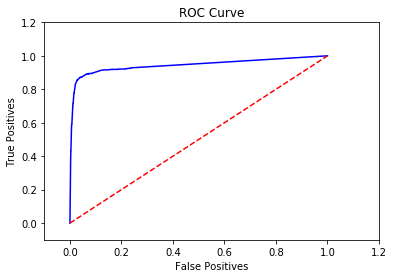

In [43]:
lrpredict = lrmodel.predict(x_test)
rfpredict = rfmodel.predict(x_test)

lrscores = lrmodel.score(x_test, y_test)
rfscores = rfmodel.score(x_test, y_test)

from sklearn.metrics import roc_curve, auc, confusion_matrix

lrconfuse = confusion_matrix(lrpredict, y_test)
rfconfuse = confusion_matrix(rfpredict, y_test)

tn, fn, fp, tp = lrconfuse.ravel()
lrsens = float(tp) / (tp+fn)
lrprec = float(tp) / (tp+fp)

tn, fn, fp, tp = rfconfuse.ravel()
rfsens = float(tp) / (tp+fn)
rfprec = float(tp) / (tp+fp)

lrprobs = lrmodel.predict_proba(x_test)[:,1:]
rfprobs = rfmodel.predict_proba(x_test)[:,1:]
import matplotlib.pyplot as plt
%matplotlib inline 

fpr, tpr, _ = roc_curve(y_test, lrprobs)
fpr, tpr, _ = roc_curve(y_test, rfprobs)
rauc = auc(fpr, tpr)
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positives')
plt.xlabel('False Positives')
rauc

In [26]:
ptable = []
for i in np.arange(0.05, 1.0, 0.05):
	predicts = np.where(lrprobs>=i, 1, 0)
	confuse = confusion_matrix(predicts, y_test)
	tn, fn, fp, tp = confuse.ravel()
	sens = float(tp) / (tp+fn)
	prec = float(tp) / (tp+fp)
	row = (i, sens, prec)
	ptable.append(row) 
    
from pprint import pprint
pprint(ptable)

[(0.05, 0.9198542805100182, 0.5098435133770823),
 (0.1, 0.8724954462659381, 0.7279635258358662),
 (0.15000000000000002, 0.8515482695810564, 0.8151700087183958),
 (0.2, 0.8287795992714025, 0.8552631578947368),
 (0.25, 0.7969034608378871, 0.884732052578362),
 (0.3, 0.773224043715847, 0.907051282051282),
 (0.35000000000000003, 0.7604735883424408, 0.9185918591859186),
 (0.4, 0.74408014571949, 0.9252548131370328),
 (0.45, 0.726775956284153, 0.9279069767441861),
 (0.5, 0.7112932604735883, 0.9330943847072879),
 (0.55, 0.6994535519125683, 0.9377289377289377),
 (0.6000000000000001, 0.6848816029143898, 0.9459119496855346),
 (0.6500000000000001, 0.6703096539162113, 0.9472329472329473),
 (0.7000000000000001, 0.6475409836065574, 0.9543624161073826),
 (0.7500000000000001, 0.6229508196721312, 0.9553072625698324),
 (0.8, 0.6029143897996357, 0.9608127721335269),
 (0.8500000000000001, 0.5710382513661202, 0.9661016949152542),
 (0.9000000000000001, 0.5318761384335154, 0.9700996677740864),
 (0.950000000000

5) Can you find any evidence that for the disease you’ve modeled, a certain drug is preferred
by a certain demographic subgroup?

In [39]:
demog = base.loc[base['diabetesDiagnosed']=='Yes']
demogs = {}
demog['marital'] = demog.married.apply(lambda x: x.replace(' IN ROUND',''))
demogs['race'] = demog.race.unique().tolist()
demogs['marital'] = demog.marital.unique().tolist()
demogs['sex'] = demog.sex.unique().tolist()
demog['agecat'] = pd.cut(demog['age'], [0,18,30,40,50,60,70,120])
demogs['agecat'] = demog.agecat.unique().tolist()

dprefer = {}
top = [row[0] for row in results1['diabetesDiagnosed']]
for demo in demogs:
	for cat in demogs[demo]:
		dm = demog[['id',demo]]
		dm[cat] = np.where(dm[demo]==cat, 1, 0)
		dm = dm.drop_duplicates()[['id',cat]]
		dprefer[cat] = []
		for med in top:
		# for med in fifty['diabetesDiagnosed']:
			md = meds.loc[meds['rxNDC']==med]
			md['value'] = 1
			mg = pd.merge(dm, md, 'left', 'id')
			mg = mg.fillna(0)
			mg = mg[['id', cat, 'value']]
			tb = mg.groupby([cat,'value'], as_index=False).count().values.tolist()
			if (len(tb)==4):
				table = [[tb[0][2], tb[1][2]],[tb[2][2], tb[3][2]]]
				oddsratio, pvalue = stats.fisher_exact(table)
				if pvalue < 0.01:
					dprefer[cat].append((oddsratio, med, ndc[med]))

		dprefer[cat] = sorted(dprefer[cat])
        
print dprefer

C:\Users\Glenn Wright\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Glenn Wright\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Glenn Wright\Anaconda2\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

{nan: [], Interval(60, 70, closed='right'): [(0.68572523225442, 53885044801L, 'ONE TOUCH ULTRA'), (1.1704358593268311, 169183411L, 'INSULIN NPH HUMAN NOVOLIN N'), (1.1989540530444527, 88222033L, 'LANTUS INSULIN'), (1.2644669211709094, 56151088880L, 'TRUETRACK SYSTEM'), (1.4433421684805217, 53885024510L, 'ONETOUCH ULTRA'), (2.242520290391016, 63653117106L, 'CLOPIDGREL')], Interval(70, 120, closed='right'): [(0.33014126236707053, 781505201L, 'METFORMIN HYDROCHLORIDE'), (0.3906877890601737, 53885044801L, 'ONE TOUCH ULTRA'), (0.4209551389450575, 53885024510L, 'ONETOUCH ULTRA'), (0.6147974617646645, 781505001L, 'METFORMIN HYDROCHLORIDE'), (0.6232101083984053, 53885052401L, 'ONETOUCH'), (0.7805422508525957, 88222033L, 'LANTUS INSULIN'), (1.3238353316664773, 2831501L, 'HUMULIN'), (1.7849240706383565, 56151088880L, 'TRUETRACK SYSTEM'), (1.8192864953005765, 63653117106L, 'CLOPIDGREL')], 'Black': [(0.6696194628674363, 53885024510L, 'ONETOUCH ULTRA'), (0.8170006881245478, 88222033L, 'LANTUS INSUL

The highest odds ratios for any demographic group I examined were for the 0-18 age category.  This makes intuitive sense - it seems likely that physicians use different guidelines for treating children than adults.  There were many other demographic differences that reached statistical significance, but the effect sizes tended to be much smaller.